In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

In [2]:
import tensorflow as tf
print(tf.__version__)

2.3.0


In [3]:
import numpy as np
import matplotlib.pyplot as plt
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

In [4]:
!wget --no-check-certificate \
    https://raw.githubusercontent.com/jbrownlee/Datasets/master/daily-min-temperatures.csv \
    -O /tmp/daily-min-temperatures.csv

--2020-09-14 19:00:47--  https://raw.githubusercontent.com/jbrownlee/Datasets/master/daily-min-temperatures.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 67921 (66K) [text/plain]
Saving to: ‘/tmp/daily-min-temperatures.csv’

/tmp/daily-min-temp 100%[===================>]  66.33K  --.-KB/s    in 0.03s   

2020-09-14 19:00:47 (2.37 MB/s) - ‘/tmp/daily-min-temperatures.csv’ saved [67921/67921]



In [5]:
!cat /tmp/daily-min-temperatures.csv

"Date","Temp"
"1981-01-01",20.7
"1981-01-02",17.9
"1981-01-03",18.8
"1981-01-04",14.6
"1981-01-05",15.8
"1981-01-06",15.8
"1981-01-07",15.8
"1981-01-08",17.4
"1981-01-09",21.8
"1981-01-10",20.0
"1981-01-11",16.2
"1981-01-12",13.3
"1981-01-13",16.7
"1981-01-14",21.5
"1981-01-15",25.0
"1981-01-16",20.7
"1981-01-17",20.6
"1981-01-18",24.8
"1981-01-19",17.7
"1981-01-20",15.5
"1981-01-21",18.2
"1981-01-22",12.1
"1981-01-23",14.4
"1981-01-24",16.0
"1981-01-25",16.5
"1981-01-26",18.7
"1981-01-27",19.4
"1981-01-28",17.2
"1981-01-29",15.5
"1981-01-30",15.1
"1981-01-31",15.4
"1981-02-01",15.3
"1981-02-02",18.8
"1981-02-03",21.9
"1981-02-04",19.9
"1981-02-05",16.6
"1981-02-06",16.8
"1981-02-07",14.6
"1981-02-08",17.1
"1981-02-09",25.0
"1981-02-10",15.0
"1981-02-11",13.7
"1981-02-12",13.9
"1981-02-13",18.3
"1981-02-14",22.0
"1981-02-15",22.1
"1981-02-16",21.2
"1981-02-17",18.4
"1981-02-18",16.6
"1981-02-19",16.1
"1981-02-20",15.7
"1981-02-21",16.6
"1981-02-22",16.5
"1981-02-23",14.4
"1981-02-24",1

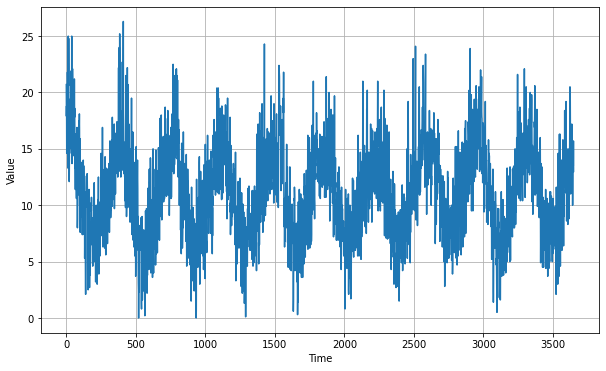

In [6]:
import csv
time_step = []
temps = []

with open('/tmp/daily-min-temperatures.csv') as csvfile:
  reader = csv.reader(csvfile, delimiter=',')
  next(reader)
  for i, row in enumerate(reader):
    temps.append(float(row[1]))
    time_step.append(i)

series = np.array(temps)
time = np.array(time_step)
plt.figure(figsize=(10, 6))
plot_series(time, series)

In [7]:
split_time = 2500
time_train = time_step[:split_time]
x_train = series[:split_time]
time_valid = time_step[split_time:]
x_valid = series[split_time:]

window_size = 30
batch_size = 32
shuffle_buffer_size = 1000


In [8]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    dataset = tf.data.Dataset.from_tensor_slices(series)
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
    dataset = dataset.shuffle(shuffle_buffer)
    dataset = dataset.map(lambda window: (window[:-1], window[1:])) # sequence-to-sequence
    return dataset.batch(batch_size).prefetch(1)


In [9]:
def model_forecast(model, series, window_size):
    # series = tf.expand_dims(series, axis=-1)
    dataset = tf.data.Dataset.from_tensor_slices(series)
    dataset = dataset.window(window_size, shift=1, drop_remainder=True)
    dataset = dataset.flat_map(lambda window: window.batch(window_size))
    dataset = dataset.batch(32).prefetch(1)
    forecast = model.predict(dataset)
    return forecast


In [10]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
window_size = 64
batch_size = 256
train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)
print(train_set)
print(x_train.shape)

model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=60, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])


<PrefetchDataset shapes: ((None, None, 1), (None, None, 1)), types: (tf.float64, tf.float64)>
(2500,)
Epoch 1/100
10/10 [==============================] - 0s 21ms/step - loss: 36.8870 - mae: 37.3865
Epoch 2/100
10/10 [==============================] - 0s 22ms/step - loss: 36.0211 - mae: 36.5205
Epoch 3/100
10/10 [==============================] - 0s 26ms/step - loss: 34.6893 - mae: 35.1886
Epoch 4/100
10/10 [==============================] - 0s 22ms/step - loss: 33.0611 - mae: 33.5601
Epoch 5/100
10/10 [==============================] - 0s 24ms/step - loss: 31.1774 - mae: 31.6762
Epoch 6/100
10/10 [==============================] - 0s 25ms/step - loss: 29.0289 - mae: 29.5273
Epoch 7/100
10/10 [==============================] - 0s 23ms/step - loss: 26.5988 - mae: 27.0967
Epoch 8/100
10/10 [==============================] - 0s 24ms/step - loss: 23.8575 - mae: 24.3547
Epoch 9/100
10/10 [==============================] - 0s 25ms/step - loss: 20.8141 - mae: 21.3104
Epoch 10/100
10/10 [=====

(1e-08, 0.0001, 0.0, 60.0)

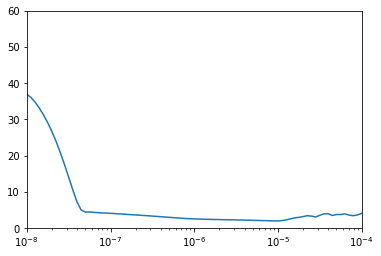

In [11]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-4, 0, 60])

In [12]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
train_set = windowed_dataset(x_train, window_size=60, batch_size=100, shuffle_buffer=shuffle_buffer_size)
model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=60, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
])


optimizer = tf.keras.optimizers.SGD(lr=1e-5, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set,epochs=150)
                                    
# EXPECTED OUTPUT SHOULD SEE AN MAE OF <2 WITHIN ABOUT 30 EPOCHS

Epoch 1/150
25/25 [==============================] - 0s 12ms/step - loss: 9.9814 - mae: 10.4694
Epoch 2/150
25/25 [==============================] - 0s 13ms/step - loss: 2.5295 - mae: 2.9922
Epoch 3/150
25/25 [==============================] - 0s 13ms/step - loss: 1.9502 - mae: 2.4047
Epoch 4/150
25/25 [==============================] - 0s 14ms/step - loss: 1.8619 - mae: 2.3151
Epoch 5/150
25/25 [==============================] - 0s 13ms/step - loss: 1.8215 - mae: 2.2733
Epoch 6/150
25/25 [==============================] - 0s 13ms/step - loss: 1.7909 - mae: 2.2418
Epoch 7/150
25/25 [==============================] - 0s 12ms/step - loss: 1.7686 - mae: 2.2186
Epoch 8/150
25/25 [==============================] - 0s 13ms/step - loss: 1.7413 - mae: 2.1906
Epoch 9/150
25/25 [==============================] - 0s 13ms/step - loss: 1.7193 - mae: 2.1681
Epoch 10/150
25/25 [==============================] - 0s 13ms/step - loss: 1.7000 - mae: 2.1482
Epoch 11/150
25/25 [============================

In [13]:
rnn_forecast = model_forecast(model, series[..., np.newaxis], window_size)
rnn_forecast = rnn_forecast[split_time - window_size:-1, -1, 0]

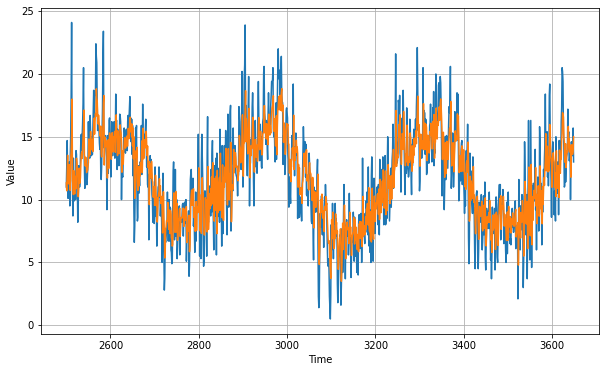

In [14]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)

# EXPECTED OUTPUT. PLOT SHOULD SHOW PROJECTIONS FOLLOWING ORIGINAL DATA CLOSELY

In [15]:
tf.keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy()

# EXPECTED OUTPUT MAE < 2 -- I GOT 1.789626

1.7796272

In [16]:
print(rnn_forecast)
# EXPECTED OUTPUT -- ARRAY OF VALUES IN THE LOW TEENS

[11.328067 10.704989 12.123897 ... 13.6036   13.795694 15.008057]
